In [1]:
#!/usr/bin/env python
#-*- coding: utf-8- -*-
import warnings 
warnings.filterwarnings("ignore")
#load prerequisite librarys  for running the code 

from osgeo import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.cluster import OPTICS
from sklearn.preprocessing import normalize, StandardScaler
import shapely

#get sample data 
dem_data = gdal.Open("ALASKA/Alaska.tif")
#set raster data as array
dem_array = dem_data.GetRasterBand(1).ReadAsArray()
dem_array[dem_array == 0] = np.nan
#get the geotransform data from the raster
transform = dem_data.GetGeoTransform()

ModuleNotFoundError: No module named 'osgeo'

In [3]:
 slope, aspect,hillshade =  hillshade(dem_array,azimuth= 90 ,angle_altitude= 100 )

NameError: name 'hillshade' is not defined

In [4]:
#print dem metadata for inspection\
print(dem_data.GetProjection())
print(transform[0])
print(transform[3])
print(transform[1])
print(transform[5])

PROJCS["NAD83 / Alaska Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3338"]]
-175680.0
1508570.0
5.0
-5.0


In [14]:
def downsample(bigarray, nbig ,nsmall):
    small_array = big.reshape([nsmall, nbig//nsmall, nsmall, nbig//nsmall]).mean(-1).mean(1)
    return small_array



def view (offset_y, offset_x, shape, step=1):
    """
    Function returning two matching numpy views for moving window routines.
    - 'offset_y' and 'offset_x' refer to the shift in relation to the analysed (central) cell 
    - 'shape' are 2 dimensions of the data matrix (not of the window!)
    - 'view_in' is the shifted view and 'view_out' is the position of central cells
    (see on LandscapeArchaeology.org/2018/numpy-loops/)
    """
    size_y, size_x = shape
    x, y = abs(offset_x), abs(offset_y)
    
    x_in = slice(x , size_x, step) 
    x_out = slice(0, size_x - x, step)

    y_in = slice(y, size_y, step)
    y_out = slice(0, size_y - y, step)
 
    # the swapping trick    
    if offset_x < 0: x_in, x_out = x_out, x_in                                 
    if offset_y < 0: y_in, y_out = y_out, y_in
 
    # return window view (in) and main view (out)
    return np.s_[y_in, x_in], np.s_[y_out, x_out]


In [15]:
from osgeo import gdal
import numpy as np

# -------------- INPUT -----------------
#elevation_model ="__path__to__my__dem__"
#output_model = "__path__to__my__output__file__"


# ----------  create the moving window  ------------
r= 200 #radius in pixels
win = np.ones((2* r +1, 2* r +1))
# ----------   or, copy paste your window matrix -------------
# win = np.array( [    [0, 1, 1, 1, 0]
#                      [1, 1, 1, 1, 1],
#                      [1, 1, 0, 1, 1],
#                      [1, 1, 1, 1, 1],
#                      [0, 1, 1, 1, 0]  ])

# window radius is needed for the function,
# deduce from window size (can be different for height and width…)
r_y, r_x  = win.shape[0]//2, win.shape[1]//2
win[r_y, r_x  ]=0  # let's remove the central cell 


# ----  main routine  -------

#dem = gdal.Open(elevation_model)
#mx_z = dem.ReadAsArray()
mx_z = dem_array
#matrices for temporary data
mx_temp = np.zeros(mx_z.shape)
mx_count = np.zeros(mx_z.shape)

# loop through window and accumulate values
for (y,x), weight in np.ndenumerate(win):
    
    if weight == 0 : continue  #skip zero values !
    # determine views to extract data 
    view_in, view_out = view(y - r_y, x - r_x, mx_z.shape)
    # using window weights (eg. for a Gaussian function)
    mx_temp[view_out] += mx_z[view_in]  * weight
    
   # track the number of neighbours 
   # (this is used for weighted mean : Σ weights*val / Σ weights)
    mx_count[view_out] += weight

# this is TPI (spot height – average neighbourhood height)
out = mx_z - mx_temp / mx_count
out = ((((out - out.mean()) / out.std()) * 100) + 0.5)
"""# writing output 
driver = gdal.GetDriverByName('GTiff')
ds = driver.Create(output_model, mx_z.shape[1], mx_z.shape[0], 1, gdal.GDT_Float32)
ds.SetProjection(dem.GetProjection())
ds.SetGeoTransform(dem.GetGeoTransform())
ds.GetRasterBand(1).WriteArray(out)
ds = None"""

np.savetxt("tpi_1000.csv" , out , delimiter= ",") 

KeyboardInterrupt: 

In [ ]:
from osgeo import gdal
import numpy as np

# -------------- INPUT -----------------
#elevation_model ="__path__to__my__dem__"
#output_model = "__path__to__my__output__file__"


# ----------  create the moving window  ------------
r= 400 #radius in pixels
win = np.ones((2* r +1, 2* r +1))
# ----------   or, copy paste your window matrix -------------
# win = np.array( [    [0, 1, 1, 1, 0]
#                      [1, 1, 1, 1, 1],
#                      [1, 1, 0, 1, 1],
#                      [1, 1, 1, 1, 1],
#                      [0, 1, 1, 1, 0]  ])

# window radius is needed for the function,
# deduce from window size (can be different for height and width…)
r_y, r_x  = win.shape[0]//2, win.shape[1]//2
win[r_y, r_x  ]=0  # let's remove the central cell 


# ----  main routine  -------

#dem = gdal.Open(elevation_model)
#mx_z = dem.ReadAsArray()
mx_z = dem_array
#matrices for temporary data
mx_temp = np.zeros(mx_z.shape)
mx_count = np.zeros(mx_z.shape)

# loop through window and accumulate values
for (y,x), weight in np.ndenumerate(win):
    
    if weight == 0 : continue  #skip zero values !
    # determine views to extract data 
    view_in, view_out = view(y - r_y, x - r_x, mx_z.shape)
    # using window weights (eg. for a Gaussian function)
    mx_temp[view_out] += mx_z[view_in]  * weight
    
   # track the number of neighbours 
   # (this is used for weighted mean : Σ weights*val / Σ weights)
    mx_count[view_out] += weight

# this is TPI (spot height – average neighbourhood height)
out = mx_z - mx_temp / mx_count
out = ((((out - out.mean()) / out.std()) * 100) + 0.5)
"""# writing output 
driver = gdal.GetDriverByName('GTiff')
ds = driver.Create(output_model, mx_z.shape[1], mx_z.shape[0], 1, gdal.GDT_Float32)
ds.SetProjection(dem.GetProjection())
ds.SetGeoTransform(dem.GetGeoTransform())
ds.GetRasterBand(1).WriteArray(out)
ds = None"""

np.savetxt("tpi_2000.csv" , out , delimiter= ",") 

In [ ]:
plt.imshow(out)
plt.title("tpi1000_res_5")
plt.colorbar()
plt.show()

In [8]:
#First, standardize the TPI grids using the formula:
#tpi<sf>_stdi = int((((tpi<sf> – mean) / stdv) * 100) + 0.5)
tpi_500 = out.copy()

In [23]:
lf300x100 = np.zeros(out.shape)

In [7]:
np.savetxt("slope.csv" , slope , delimiter= ",")
np.savetxt("aspect.csv" , aspect , delimiter= ",")


In [7]:
#def LF_TPI(big_TPI_array ,small_TPI_array ,slope_array_deg )
big_TPI_array = tpi_300
small_TPI_array = tpi_100
slopei_deg  = slope_array
std = big_TPI_array.std()
lf300x100 = np.zeros(big_TPI_array.shape)

# LF = 5 | Broad Flat Areas | (slope = 0)
lf300x100[((small_TPI_array > -std) & (small_TPI_array < std)) & ((big_TPI_array > -std) & (big_TPI_array < std)) & (slope_array_deg <= 5)] = 5

# LF = 6 | Broad open slopes | (slope > 0)
lf300x100[((small_TPI_array > -std) & (small_TPI_array < std)) & ((big_TPI_array > -std) & (big_TPI_array < std)) & (slope_array_deg >= 6)] = 6

# LF = 7 | flat ridge tops | mesa tops
lf300x100[((small_TPI_array > -std) & (small_TPI_array < std)) & (big_TPI_array >= std)] = 7

# LF = 4 | U-shape valleys
lf300x100[((small_TPI_array > -std )& (small_TPI_array < std)) & (big_TPI_array <= -std)] = 4

# LF = 2 | Lateral midslope | incised drainages
lf300x100[(small_TPI_array <= -std) & ((big_TPI_array > -std )& (big_TPI_array < std))] = 2

# LF = 9 | Lateral midslope |drainage divides
lf300x100[(small_TPI_array >= std) & ((big_TPI_array > -std) & (big_TPI_array < std))] = 9

# LF = 3 | Upland incised |drainages |Stream headwaters
lf300x100[ (small_TPI_array <= -std) & (big_TPI_array >= std)] = 3

# LF = 1 | V-shape river valleys | Deep narrow canyons
lf300x100[(small_TPI_array <= -std) & (big_TPI_array <= -std)] = 1

# LF = 10 | mountain tops | High narrow ridges
lf300x100[(small_TPI_array >= std) & (big_TPI_array >= std)] = 10

# LF = 8 |Local ridge/hilltops within | broad valleys
lf300x100[(small_TPI_array >= std) & (big_TPI_array <= -std)] = 8


SyntaxError: invalid syntax (Temp/ipykernel_473764/4118960586.py, line 1)

In [ ]:
%matplotlib
plt.imshow(lf300x100)
plt.title("lf300x100")
plt.colorbar()
plt.show()

In [1]:
%matplotlib

Using matplotlib backend: TkAgg


C:\Users\matan\.conda\envs\ox\lib\site-packages\ipykernel\eventloops.py:256: RuntimeWarning: coroutine 'Kernel.do_one_iteration' was never awaited
  self.func()


In [141]:
small_TPI_array_between_pos_neg_std = np.where((small_TPI_array > -100) & (small_TPI_array < 100))
small_TPI_array_between_pos_neg_std = list(zip(small_TPI_array_between_pos_neg_std[:][0],small_TPI_array_between_pos_neg_std[:][1]))

def commun_val_lsts(list1 , list2):
    return [element for element in list1 if element in list2]




if (small_TPI_array > -100 and small_TPI_array < 100 and big_TPI_array > -100 and big_TPI_array < 100 and slopei_deg <= 5):
    lf300x100 = 5
elif (small_TPI_array > -100 and small_TPI_array < 100 and big_TPI_array > -100 and big_TPI_array < 100 and slopei_deg >= 6):
    lf300x100 = 6
elif (small_TPI_array > -100 and small_TPI_array < 100 and big_TPI_array >= 100):
    lf300x100 = 7
elif (small_TPI_array > -100 and small_TPI_array < 100 and big_TPI_array <= -100):
    lf300x100 = 4
elif (small_TPI_array <= -100 and big_TPI_array > -100 and big_TPI_array < 100):
    lf300x2k = 2
elif (small_TPI_array >= 100 and big_TPI_array > -100 and big_TPI_array < 100):
    lf300x100 = 9
elif (small_TPI_array <= -100 and big_TPI_array >= 100):
        lf300x100 = 3
elif (small_TPI_array <= -100 and big_TPI_array <= -100):
        lf300x100 = 1
elif (small_TPI_array >= 100 and big_TPI_array >= 100):
    lf300x100 = 10
elif (small_TPI_array >= 100 and big_TPI_array <= -100):
    lf300x100 = 8

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [5]:
#without np.mean()
def half_res_avg(im):
    original_width = im.shape[1]
    original_hight = im.shape[0]
    
    width = original_width / 2
    hight = original_hight / 2
    
    resized_image = np.zeros(shape = (hight, width, 3) ,dtype = np.uint8)
    scale = 2
    for i in range(hight):
        for j in range(width):
            temp = np.array([0,0,0])
            for x in range(scale):
                for y in range(scale):
                    temp += im[i*scale + x, j*scale+y]
            resized_image[i, j] = temp / (scale * scale)
    return resized_image

#with numpy.mean()
def downsample_res_avg(im , scale):
    original_width = im.shape[1]
    original_hight = im.shape[0]
    
    width = int( original_width / scale)
    hight = int(original_hight / scale)
    
    resized_image = np.zeros(shape = (hight, width, 3) ,dtype = np.uint8)
    
    for i in range(0, original_hight , scale):
        for j in range(0, original_width , scale):
            resized_image[int(i/scale)-1 , int(j/scale)-1 ] = np.mean(im[i:(i + scale), j:(j + scale)], axis = (0,1))
            
    return resized_image

def calculate_slope(elv, cellsize, in_degrees = False):
    #evaluate gradient im two dimensions
    px, py = np.gradient(elv, cellsize)
    slope = np.sqrt(px**2 + py**2)
    if in_degrees is True:
        slope_deg = np.degrees(np.arctan(slope))
        return slope_deg
    return slope
    

def hillshade(array, azimuth, angle_altitude):
    azimuth = 360 - azimuth
    x,y = np.gradient(array)
    slope = np.degrees((np.pi/2 - np.arctan(np.sqrt(x*x + y*y))))
    aspect = np.arctan2(-x,y)
    azimuth_rad = azimuth *np.pi/180
    altitude_rad = angle_altitude*np.pi/180

    shaded = np.sin(altitude_rad)*np.sin(slope) + np.cos(altitude_rad)*np.cos(slope)*np.cos((azimuth - np.pi/2)  - aspect)
    hillshade = 255 * (shaded + 1)/2
    return slope, aspect,hillshade


# polygonize 
"""gdal.Polygonize()
or
rasterio.features.shapes()
or
shapely.geometry.MultiPolygon()"""

'gdal.Polygonize()\nor\nrasterio.features.shapes()\nor\nshapely.geometry.MultiPolygon()'

In [173]:
lf300x100

array([[0., 0., 5., ..., 5., 5., 5.],
       [0., 0., 5., ..., 5., 5., 5.],
       [0., 0., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 0., 0., 0.],
       [5., 5., 5., ..., 0., 0., 0.],
       [5., 5., 5., ..., 0., 0., 0.]])

In [170]:
((small_TPI_array > -100) & (small_TPI_array < 100))

array([[False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [158]:
np.where((small_TPI_array > -100) & (small_TPI_array < 100)) in np.where((big_TPI_array > -100) in (big_TPI_array < 100)) & np.where(slopei_deg <= 5)


TypeError: unsupported operand type(s) for &: 'tuple' and 'tuple'

In [162]:
list(zip(np.where((small_TPI_array > -100) & (small_TPI_array < 100)[0], np.where((small_TPI_array > -100) & (small_TPI_array < 100)[1])))

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_128792/4271053850.py, line 1)

In [166]:
x = np.where((small_TPI_array > -100) & (small_TPI_array < 100))
list(zip(x[:][0], x[:][1]))

[(0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 57),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),
 (0, 101),
 (0, 102),
 (0, 103),
 (0, 104),
 (0

In [152]:
nrows , ncols = small_TPI_array.shape
dtype = {"names":["f{}".format(i) for i in range(ncols)], "formats": ncols * [small_TPI_array.dtype]}
np.intersect1d(np.where((small_TPI_array > -100) & (small_TPI_array < 100)).view(dtype) ,np.where((big_TPI_array > -100) in (big_TPI_array < 100)).view(dtype))


AttributeError: 'tuple' object has no attribute 'view'

In [ ]:
if (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi > -100 and tp2000_stdi < 100 and slope_array*10 <= 5):
    lf300x100[] = 5
elif (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi > -100 and tp2000_stdi < 100 and slopei_deg >= 6):
    lf300x100 = 6
elif (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi >= 100):
    lf300x100 = 7
elif (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi <= -100):
    lf300x100 = 4
elif (tp300_stdi <= -100 and tp2000_stdi > -100 and tp2000_stdi < 100):
    lf300x2k = 2
elif (tp300_stdi >= 100 and tp2000_stdi > -100 and tp2000_stdi < 100):
    lf300x100 = 9
elif (tp300_stdi <= -100 and tp2000_stdi >= 100):
        lf300x100 = 3
elif (tp300_stdi <= -100 and tp2000_stdi <= -100):
        lf300x100 = 1
elif (tp300_stdi >= 100 and tp2000_stdi >= 100):
    lf300x100 = 10
elif (tp300_stdi >= 100 and tp2000_stdi <= -100):
    lf300x100 = 8

In [139]:
slope_array = calculate_slope(dem_array,5, in_degrees= True)

In [ ]:
dem_res10_array = half_res_avg(dem_array , 2)

In [100]:
x,y = np.gradient(dem_array)
slope = np.pi/2 - np.arctan(np.sqrt(x*x + y*y))
aspect = np.arctan2(-x,y)

In [ ]:

plt.imshow(aspect, cmap="terrain_r")
plt.title("aspect")
plt.colorbar()
plt.show()

#### plt.imshow(slope*10, cmap="terrain_r")
plt.title("slope")
plt.colorbar()
plt.show()

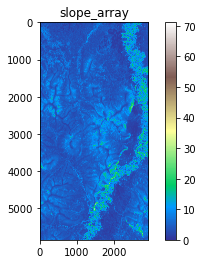

In [140]:
plt.imshow(slope_array, cmap="terrain")
plt.title("slope_array")
plt.colorbar()
plt.show()

In [ ]:
ax, fig = plt.subplots()
ax.histplot(slope_array, bins = 5)


In [111]:
plt.hist(x = slope_array[:100,:100],bins= 1000)
plt.axvline(slope_array.mean(), color = "r")
plt.axvline(slope_array.mean() + slope_array.std(), color = "r")
plt.axvline(slope_array.mean() + slope_array.std()*2, color = "r")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000006B2C62EB80> (for post_execute):


KeyboardInterrupt: 

In [ ]:
if (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi > -100 and \
tp2000_stdi < 100 and slopei_deg <= 5) lf300x100 = 5
else if (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi > -100 and \
tp2000_stdi < 100 and slopei_deg >= 6) lf300x100 = 6
else if (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi >= 100) \
lf300x100 = 7
else if (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi <= -100) \
lf300x100 = 4
else if (tp300_stdi <= -100 and tp2000_stdi > -100 and tp2000_stdi < 100) \
lf300x2k = 2
else if (tp300_stdi >= 100 and tp2000_stdi > -100 and tp2000_stdi < 100) \
lf300x100 = 9
else if (tp300_stdi <= -100 and tp2000_stdi >= 100) lf300x100 = 3
else if (tp300_stdi <= -100 and tp2000_stdi <= -100) lf300x100 = 1
else if (tp300_stdi >= 100 and tp2000_stdi >= 100) lf300x100 = 10
else if (tp300_stdi >= 100 and tp2000_stdi <= -100) lf300x100 = 8

In [ ]:
/* First, standardize the TPI grids using the formula:
/* tpi<sf>_stdi = int((((tpi<sf> – mean) / stdv) * 100) + 0.5)



tp300_stdi = int((((tp300i - 0.399) / 7.566) * 100) + .5)
tp2000_stdi = int((((tp2000i - 0.346) / 89.435) * 100) + .5)



/* Then classify the plane in Fig 4a by 1 stdv units (= 100 grid value units),
and check /* the slope for the central zone:
if (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi > -100 and \
tp2000_stdi < 100 and slopei_deg <= 5) lf300x2k = 5
else if (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi > -100 and \
tp2000_stdi < 100 and slopei_deg >= 6) lf300x2k = 6
else if (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi >= 100) \
lf300x2k = 7
else if (tp300_stdi > -100 and tp300_stdi < 100 and tp2000_stdi <= -100) \
lf300x2k = 4
else if (tp300_stdi <= -100 and tp2000_stdi > -100 and tp2000_stdi < 100) \
lf300x2k = 2
else if (tp300_stdi >= 100 and tp2000_stdi > -100 and tp2000_stdi < 100) \
lf300x2k = 9
else if (tp300_stdi <= -100 and tp2000_stdi >= 100) lf300x2k = 3
else if (tp300_stdi <= -100 and tp2000_stdi <= -100) lf300x2k = 1
else if (tp300_stdi >= 100 and tp2000_stdi >= 100) lf300x2k = 10
else if (tp300_stdi >= 100 and tp2000_stdi <= -100) lf300x2k = 8
endif

# to do
- generate copy raster full of 0 values and replace with class values
- calculate slope with gdal or with a self writen algo
- add azimoth calculatetor function
- add slope function
- downsample data to res_10
